# Food For Thought 

_ADA december, 2018._ 

Project members: 
- Micheal Lassi
- Elisabetta Pagliara
- Tom Mingasson

## Index

**0) Import and initializations** 

**1) Digging into the dataset**

    a. Missing values
    b. Country distribution
    c. Food categories healthiness
    d. Some more food plots
    e. Let's classify everything !
    f. Food advisor score
    g. Country analysis

**2) Analysis of the french market**

+ A. Health analysis via the nutri-score
        a. load and clean
        b. Load cleaned data
        c. Food quality in France
        d. Food quality for each french food brand
        e. Category Distribution in the 10 biggest food brands in France.
        f. Nutrition grade repartition per category in France
        g. Score each brand from nutrition score ratios
        
+ B. Palm Oil analysis in France
        a. load and clean
        b. Load cleaned data
        c. Palm oil presence in the whole french market
        d. Palm oil presence for each french food brand


## 0) Import and initializations

In [71]:
import itertools
import warnings
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D
from difflib import get_close_matches
import re
%matplotlib inline

# plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tools

# sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# spark
import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F

from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
spark

We set some basic plot properties with seaborn

In [3]:
style.use('seaborn-notebook') #sets the size of the charts
style.use('ggplot')

## 1) Digging into the dataset

The first step of this project aims at understanding the dataset we have chosen ([Open Food Facts Database](https://world.openfoodfacts.org/)), to check whether it is suitable for the kind of analysis we want to develop.

As a reminder, we would like to focus our research on two main topics:
1. Impact of food on environment
2. Impact of food on the health

As a first operation, we load our dataset in .csv format. The separator of each field is a tab (\t)

In [4]:
data = spark.read.csv('./data/en.openfoodfacts.org.products.csv',header=True,sep='\t')          

In [5]:
number_of_products = data.select('code').count()
number_of_products

685395

There are about 700k products in the dataset, with the following features:

In [6]:
data.columns

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'serving_quantity',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_

### a. Missing values

Despite the large number of features, we need to check how many values are missing for each of them. Note that the dataset is mostly curated on a volunteer basis (each user can add product information), hence we expect to have many missing values, especially for the less common columns. 

In order to verify that, we count the missing values in each column and we convert the result to a Pandas dataframe, for plotting ease. The missing values are plotted in proportion of the total number of products. 

In [7]:
missing_data_count = data.select([F.count(F.when(data[c].isNull(),c)).alias(c) \
                                  for c in data.columns]).toPandas()

missing_data_count = missing_data_count * 100 / number_of_products #in percent

missing_data_count = missing_data_count.transpose().sort_values(by = 0, axis = 0).rename(columns = {0:'missing'})
missing_data_count.tail()
missing_data_count.to_pickle('missing_data_count')

In [8]:
missing_data_count = pd.read_pickle('missing_data_count')

We already notice that some of the columns have completely missing values (100 % of the products). To better visualize the rest, we use a bar chart. Since the number of features is high, we only show in the plot the features who have less then 80% missing values. Those features can be better used for the analysis.

In [9]:
thresh = 80

plot = [go.Bar(x = list(missing_data_count[missing_data_count['missing'] < thresh].index),y = missing_data_count[missing_data_count['missing'] < thresh].values)]#.plot(kind = 'bar',figsize=(15, 6), legend="")

fig = go.Figure(data = plot)
py.iplot(fig, filename='mpl-basic-bar')

[Link to the plot](https://plot.ly/~eliBetta/8/)

As expected, most of the columns have a large number of missing values. Luckily enough, basic nutrition information (such as energy per 100g, proteins per 100g and so on) have less than 20% missing values. As long as we will work with single variables, the missing values will not compromise our analysis, as we will simply handle a smaller sample (hence we will have a smaller statistical power). The real problem could arise when we will use multiple variables together, as we will have to use only those products that have non-missing values for all the considered columns. For some columns, it could be possible to fill some of the missing gaps by knowledge of the relationship with other columns (e.g.:  if we have information about energy_100g, fat_100g, protein_100g, we can reconstruct the value of carbohydrates_100g as it is connected with all the others). However, this is not possible in general (e.g. with columns like packaging).

### b. Country distribution

Another important initial aspect to evaluate are the countries for which we have data available. In fact, the Open Food Facts project started in France, hence we expect to have a larger number of products coming from this country. At the same time, this kind of information allows us to understand the scopes of our research (i.e. how much it can be generalized).

In [10]:
country_value = data.groupby('countries_en').count().toPandas()
country_value = country_value.sort_values(by = 'count', ascending = False)
country_value.head()
country_value.to_pickle('country_value')

In [11]:
country_value=pd.read_pickle('country_value')

In [12]:
plot =[go.Bar(x=country_value.iloc[0:5,0].values,y=country_value.iloc[0:5,1].values)]
layout = go.Layout(
    autosize=True,
    title='First 5 countries for product number',
    width=500,
    height=500,
    yaxis=go.layout.YAxis(
        title='Number of products',
        automargin=True,
        
    ))
fig = go.Figure(data=plot, layout=layout)
py.iplot(fig, filename='automargin')

[Link to the plot](https://plot.ly/~eliBetta/10/first-5-countries-for-product-number/)

We plot the number of products for the first 5 countries.

In [13]:
N_fr = country_value.iloc[0]
N_us = country_value.iloc[1]

print("number of products sold in France: ", N_fr.values[1])
print("number of products sold in the United States: ", N_us.values[1])

number of products sold in France:  413107
number of products sold in the United States:  173495


We can see that the large majority of the products come from France, so our analysis will mostly focus on that country. In case we will do a comparison among countries, we will be careful with our conclusions (since the dishomogeneity in the dataset could lead to bias). Note that some countries' name appear concatenated in the country_en column (like "Germany,Spain"). For now, we will not handle these cases, since they are a minority compared to the France and US data.

### c. Food categories healthiness

Now that we have analyzed our dataset in general, we will focus more on some specific features of interest. In particular, we will handle subsets of the original dataframe on which we conduct our processing.
One of this subset contains the basic nutritional features (energy, protein, fat, carbohydrates, sugar, salt and sodium content) along with the categorization done by PNNS ([Programme national nutrition santé](http://www.mangerbouger.fr/PNNS)). The PNNS categorizes food products in 9 groups. We want to understand whether the nutritional basic infos are able to discriminate among these groups. In that case, we will be able to categorize the other products of the dataset (that do not fall in one of the pnns_groups) and also get an idea of the healthiness of the category. On the other side, a negative results on this will indicate us that more features are needed to determine the categorization of a product.

We select only the column of interest mentioned above, and we drop the rows that either have a null pnns value or an 'unknown' one. At the same time we create another dataframe, containing the nutritional information for the products which have a nutrition score. In this way we will be able to extend (through the use of a classifier) the nutrition score to all the products that present nutritional information.

In [14]:
columns = ["pnns_groups_1","energy_100g","fat_100g","sugars_100g",\
                       "proteins_100g","carbohydrates_100g","sodium_100g",\
                       "salt_100g","product_name",\
                       "ingredients_from_palm_oil_n",\
                       "nutrition_grade_fr"]
data_nutri = data.select(columns) # dataset for pnns_groups
data_nutri_2 = data_nutri # dataframe for score classification

In [15]:
# cleaning the categories by removing null values and the unknown pnns_group
data_nutri_2 = data_nutri_2.where(data_nutri_2.nutrition_grade_fr.isNotNull()).drop(data_nutri.pnns_groups_1)
data_nutri = data_nutri.where(data_nutri.pnns_groups_1.isNotNull()).filter(data.pnns_groups_1!='unknown').drop(data_nutri.nutrition_grade_fr)


We then observe the unique values that pnns_groups has:

In [16]:
data_nutri.select('pnns_groups_1').distinct().collect()

[Row(pnns_groups_1='salty-snacks'),
 Row(pnns_groups_1='Cereals and potatoes'),
 Row(pnns_groups_1='cereals-and-potatoes'),
 Row(pnns_groups_1='Fat and sauces'),
 Row(pnns_groups_1='fruits-and-vegetables'),
 Row(pnns_groups_1='sugary-snacks'),
 Row(pnns_groups_1='Beverages'),
 Row(pnns_groups_1='Sugary snacks'),
 Row(pnns_groups_1='Fruits and vegetables'),
 Row(pnns_groups_1='Composite foods'),
 Row(pnns_groups_1='Salty snacks'),
 Row(pnns_groups_1='Fish Meat Eggs'),
 Row(pnns_groups_1='Milk and dairy products')]

Looking at the unique values of the pnns_group1 we can observe that we can shorten some categories that contain the same name: salty-snacks, cereals and potatoes, fruits and vegetables. We need to merge them in the same category.

In [17]:
# substitute - with a blank space
data_nutri=data_nutri.withColumn('pnns_groups_1',(F.regexp_replace('pnns_groups_1', '-', ' ')))

# convert all the categories names to have initial capital letter
square_udf_int = F.udf(lambda z: z.title())

data_nutri = data_nutri.withColumn('pnns_groups_1',square_udf_int('pnns_groups_1'))
data_nutri.select('pnns_groups_1').distinct().collect()

[Row(pnns_groups_1='Cereals And Potatoes'),
 Row(pnns_groups_1='Composite Foods'),
 Row(pnns_groups_1='Sugary Snacks'),
 Row(pnns_groups_1='Beverages'),
 Row(pnns_groups_1='Fat And Sauces'),
 Row(pnns_groups_1='Fruits And Vegetables'),
 Row(pnns_groups_1='Milk And Dairy Products'),
 Row(pnns_groups_1='Fish Meat Eggs'),
 Row(pnns_groups_1='Salty Snacks')]

In [18]:
data_nutri.count()

130621

Now we have the 9 categories as originally intended. Since we have only 130k products and a few columns, we can pass the data to Pandas for further processing.

In [19]:
data_nutri_pd = data_nutri.toPandas()
data_nutri_pd2 = data_nutri_2.toPandas()

In [20]:
data_nutri_pd.to_pickle('data_nutri')
data_nutri_pd2.to_pickle('data_nutri2')

In [21]:
data_nutri_pd=pd.read_pickle('data_nutri')
data_nutri_pd2 = pd.read_pickle('data_nutri2')

We create one table to show some examples of products coming from each category (for the data story)

In [22]:
data_table=np.zeros((10,9))
df = pd.DataFrame(data=data_table, dtype=np.float)          

name=[]
for i,  group in enumerate(data_nutri_pd[['pnns_groups_1','product_name']].groupby('pnns_groups_1')):
        df.iloc[:,i]=pd.Series(group[1]['product_name'][:10]).values
        name.append(group[0])


trace = go.Table(
    header=dict(values=list(name),
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[df.iloc[:,0], df.iloc[:,1],df.iloc[:,2],df.iloc[:,3],df.iloc[:,4],df.iloc[:,5],df.iloc[:,6],df.iloc[:,7],df.iloc[:,8]],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))

data_table = [trace] 
py.iplot(data_table, filename = 'product_table')

[Link to the table](https://plot.ly/~eliBetta/12/)

We convert the numeric columns from 'object' type to 'float':

In [23]:
numeric_columns = ['energy_100g','fat_100g','carbohydrates_100g',\
                   'sugars_100g','proteins_100g',"sodium_100g","salt_100g"]

data_nutri_pd[numeric_columns] = data_nutri_pd[numeric_columns].apply(pd.to_numeric)
data_nutri_pd2[numeric_columns] = data_nutri_pd2[numeric_columns].apply(pd.to_numeric)

In [24]:
data_nutri_pd.head()

,pnns_groups_1,energy_100g,fat_100g,sugars_100g,proteins_100g,carbohydrates_100g,sodium_100g,salt_100g,product_name,ingredients_from_palm_oil_n
0,Fruits And Vegetables,657.0,0.0,27.0,0.6,36.0,0.000000,0.000,Compote de poire,None
1,Cereals And Potatoes,669.0,2.2,0.6,9.5,25.2,0.140945,0.358,BAguette bressan,0
2,Fish Meat Eggs,1059.0,17.0,0.5,23.0,0.5,0.984252,2.500,Pavé de saumon fumé à la ficelle,None
3,Composite Foods,450.0,2.2,0.5,6.8,15.3,0.275591,0.700,Blanquette de Volaille et son Riz,0
4,Composite Foods,455.0,4.2,1.4,4.4,12.5,0.236220,0.600,Raviolini au Fromage de chèvre et Pesto,None


We compute the correlation matrix for the numeric features, not discriminated by category. 

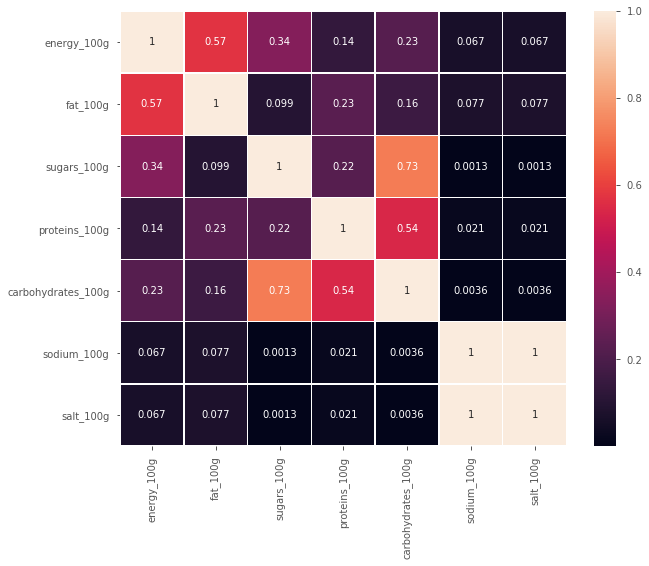

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(data_nutri_pd.corr(), annot = True, linewidths=.5)
plt.show()


We can observe that, expectedly, some columns are well correlated (e.g. sugars and carbohydrates) while others have mmuch lower correlation. One thing it's worth noticing. Sodium and salt have exactly 1 as correlation value. Hence, the two columns are the same and we should only consider one of them.

In [26]:
data_nutri_pd = data_nutri_pd.drop(columns = 'sodium_100g')
data_nutri_pd2 = data_nutri_pd2.drop(columns = 'sodium_100g')

For the sake of visualization, we show the scatterplot of two variables divided by category. This could give us further insights on the data.

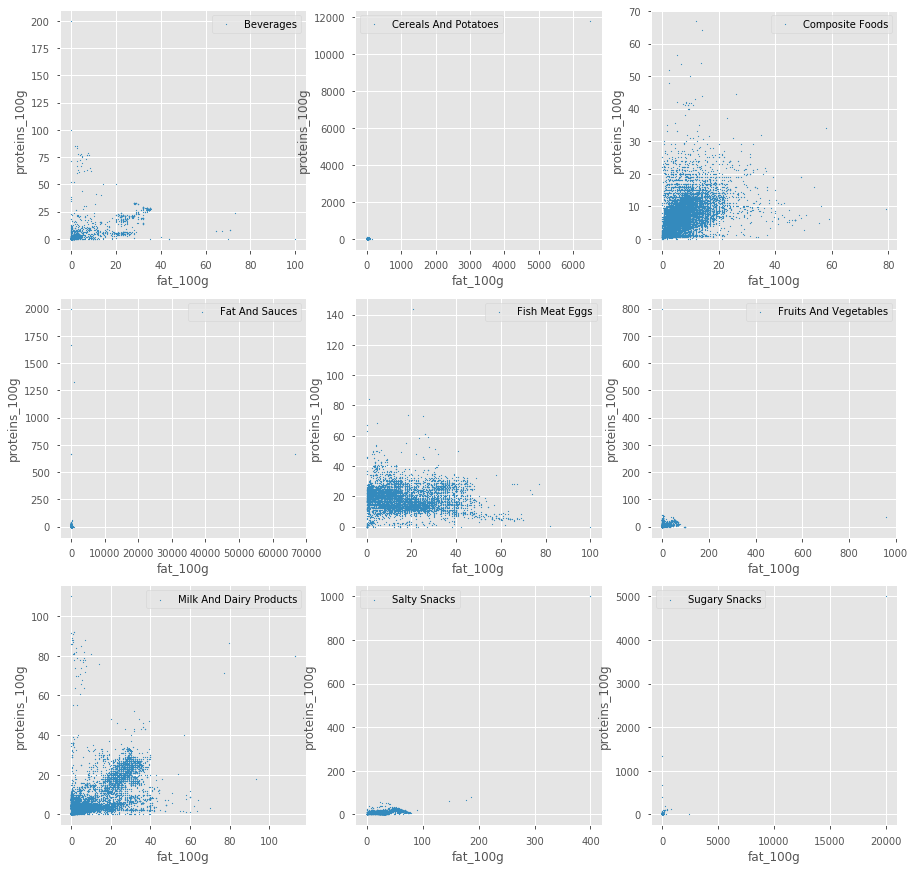

In [27]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='fat_100g',y='proteins_100g',ax=ax[i // 3][i % 3],label=name, s = 0.5)
    
plt.show() 


We can see two interesting things: there are outliers that have unrealistic values (the fat in 100g of products cannot be more than 100g) and each category of food has a different correleration. Hence, we proceed at cleaning the impossible values with the following rule: for nutrients no values should overcome 100 (as discussed for the fat). For energy (that is measured in kJ) the value should not overcome 5000 (supposing each g of fat brings 9 kcal, 100g fats would bring 900 kcal, that are approximately 5000 kJ). We also drop columns containing nan values as they would be not considered in the analysis.

In [28]:
#constrain the data : energy<5000 and fat<100
def filterData(data,ParameterEnergy,Parameter):
    columns=data.filter(regex='_100g').columns
    for i in columns:
        if i=='energy_100g':
            data = data[data[i]<ParameterEnergy]
        else:
            data = data[data[i]<Parameter]
    return data

data_nutri_pd['ingredients_from_palm_oil_n'] = data_nutri_pd['ingredients_from_palm_oil_n'].fillna(0)
data_nutri_pd2['ingredients_from_palm_oil_n'] = data_nutri_pd2['ingredients_from_palm_oil_n'].fillna(0)

data_nutri_pd = filterData(data_nutri_pd,5000,100).dropna() 
data_nutri_pd2 = filterData(data_nutri_pd2,5000,100).dropna()

We plot again the correlation heatmap, without outliers. We do it directly divided in categories

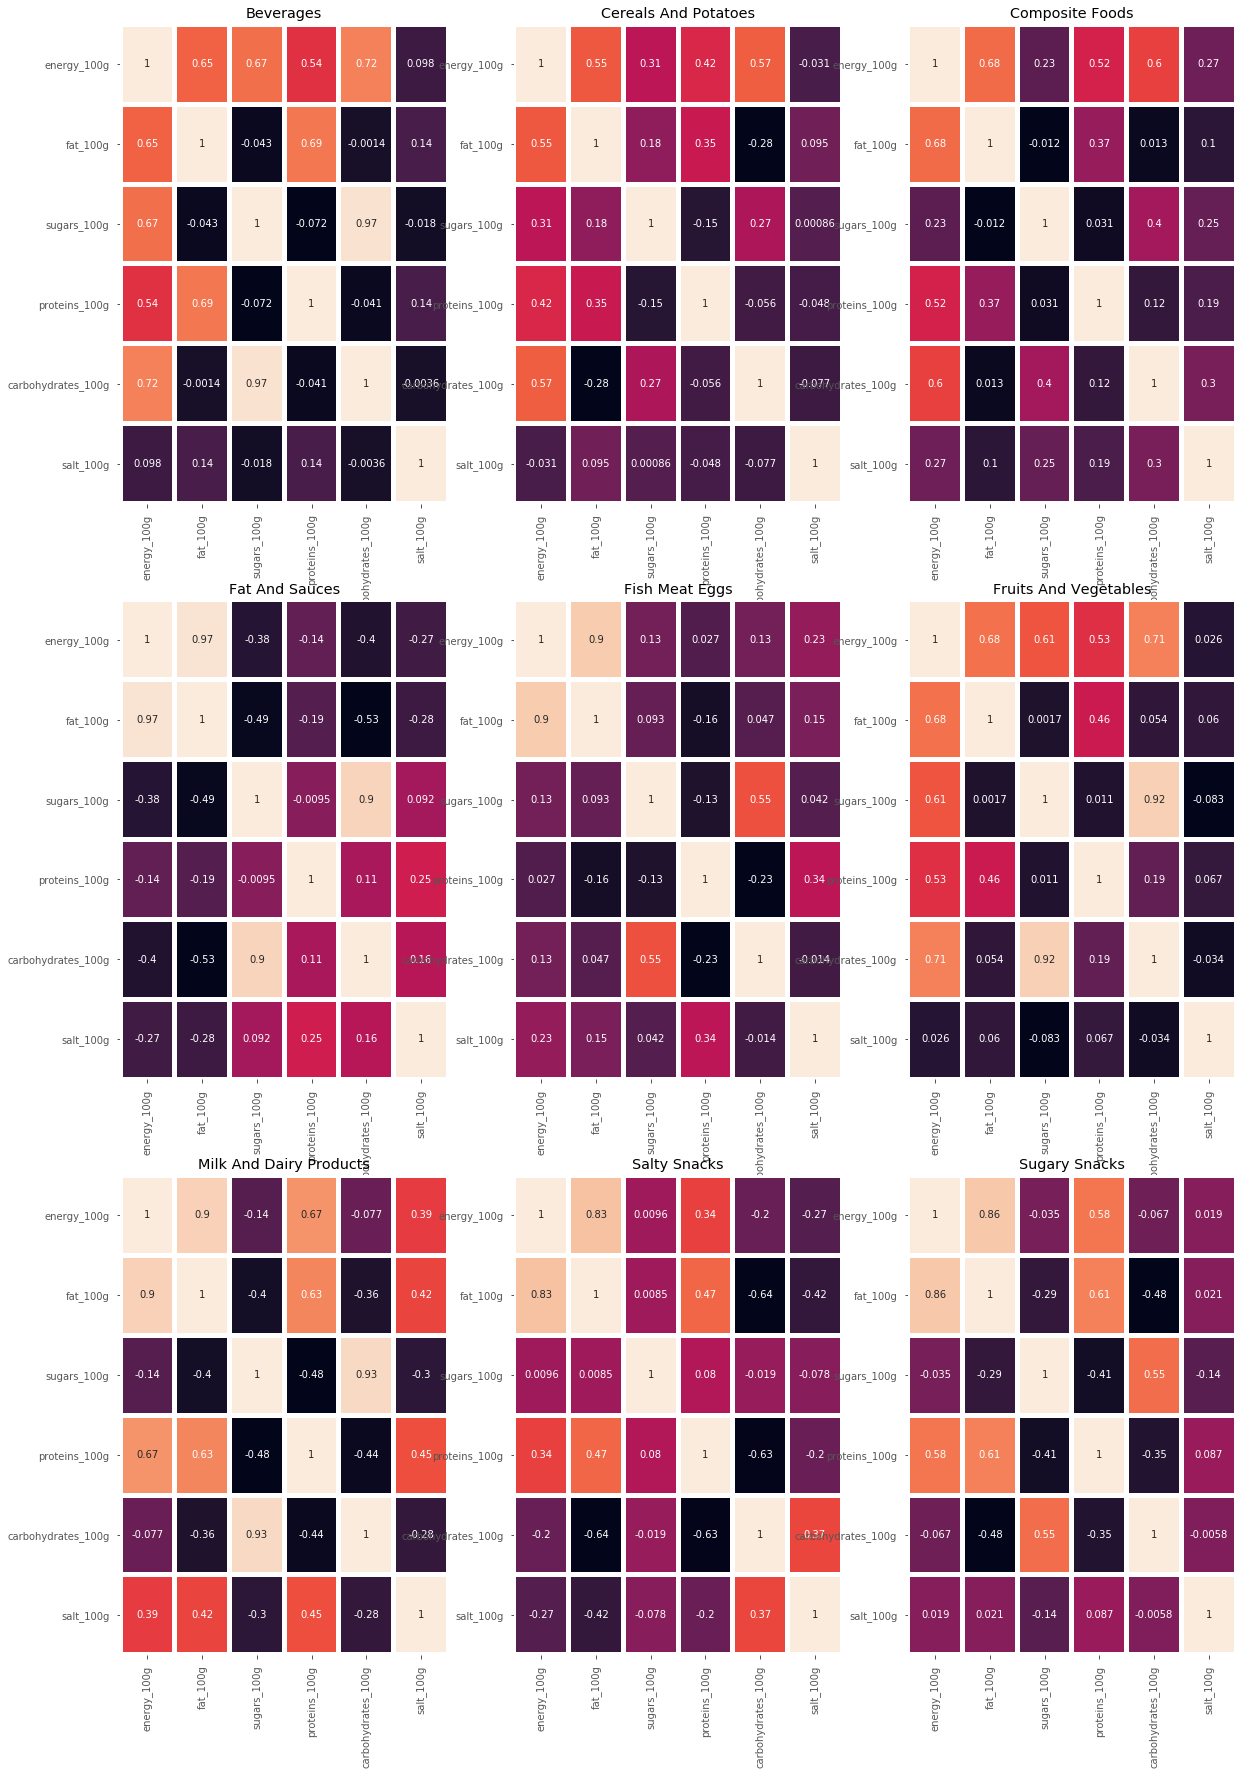

In [29]:
fig,ax = plt.subplots(3,3,figsize=(20,30))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    plt.subplot(3,3,i+1)
    sns.heatmap(group.corr(), annot = True,  linewidths=4, cbar = False)
    plt.title(name)

plt.show()

We can see that some of the categories share similar values of correlations, while other have completely different patterns (e.g. "Fat and sauces" and "Fruits and Vegetables" have opposite sign in some of the correlations values). We show this difference for the exemplar features "sugars_100g" and "energy_100g".

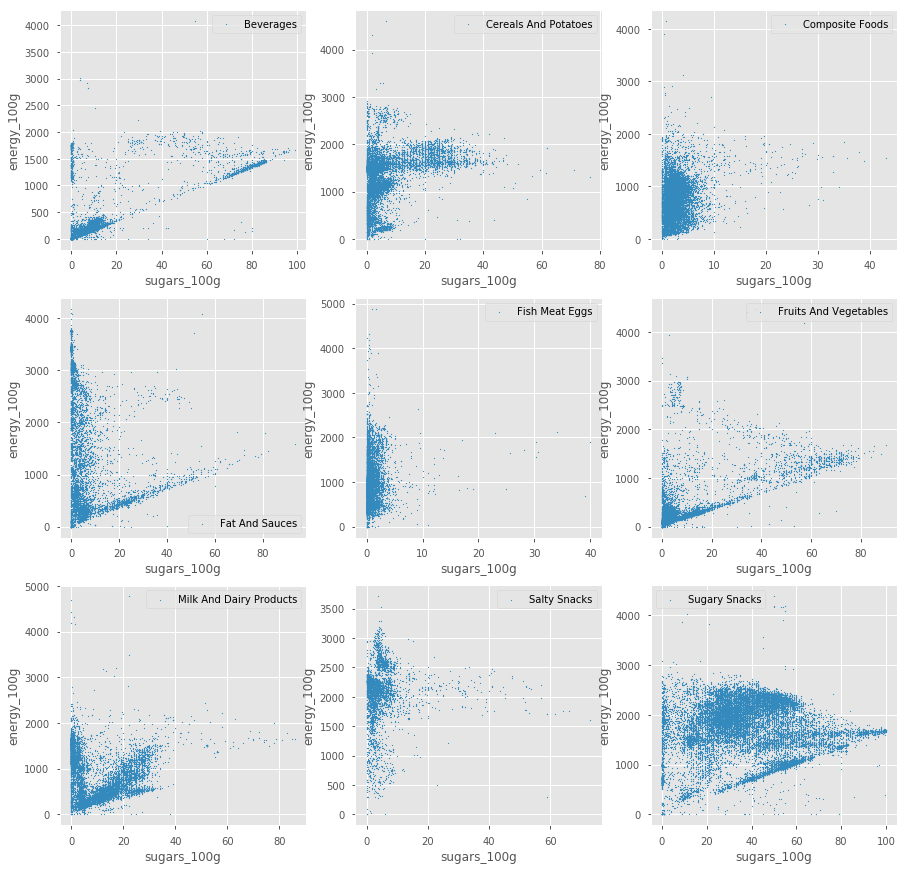

In [30]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

for i, (name, group) in enumerate(data_nutri_pd.groupby('pnns_groups_1')):
    
    group.plot(kind='scatter',x='sugars_100g',y='energy_100g',ax=ax[i // 3][i % 3],label=name, s = 0.5)
    
plt.show()   

We now visualize the distribution of one single column along categories, to check the separability of the classes. We chose 'fat_100g' for the visualization.

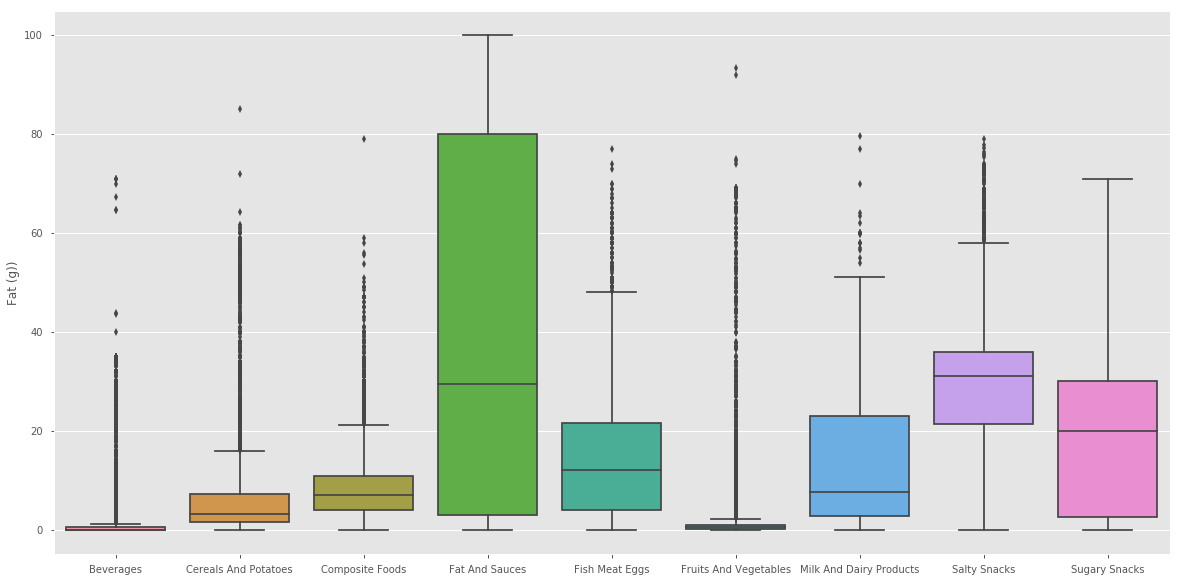

In [31]:
fig,ax=plt.subplots(figsize=(20,10))
nutri = []
for i, (name, group) in enumerate(data_nutri_pd[['pnns_groups_1','fat_100g']].groupby('pnns_groups_1')):
    nutri.append(group['fat_100g'].values)
    
nutri=np.asarray(nutri)    
g=sns.boxplot(data= nutri)
plt.xticks(plt.xticks()[0],sorted(data_nutri_pd.pnns_groups_1.unique()))

plt.ylabel('Fat (g))')
plt.show()

The classes show different distributions for this features, suggesting there could be a good separability when using more features. To analyze the categorization of the data with all the features and visualize it, we decide to perform a PCA and retain the first three principal components.

In [32]:
# save the dataframes for the classification
data_nutri_pd.to_pickle('data_nutri')
data_nutri_pd2.to_pickle('data_nutri2')

In [33]:
# prepare the dataset

X=data_nutri_pd.iloc[:,1:7].values # nutritional values
y=data_nutri_pd.iloc[:,0].values#LABELS
product =  data_nutri_pd.iloc[:,7]
#standardize values
X_std = StandardScaler().fit_transform(X)

#compute pca
pca = PCA(n_components=3)
Y = pca.fit_transform(X_std)

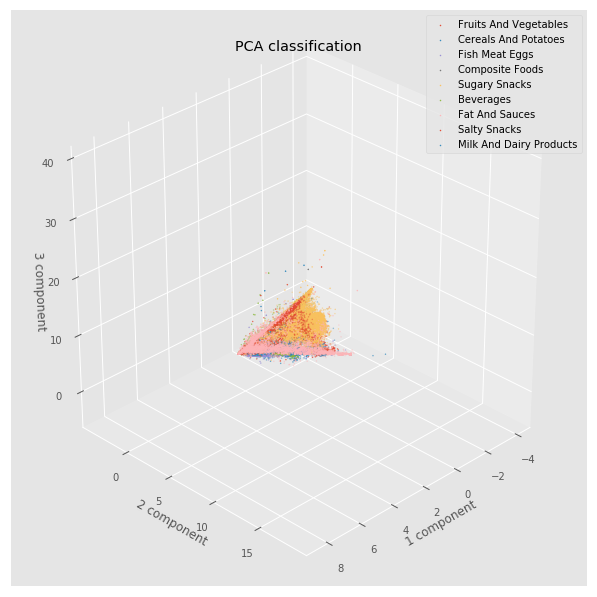

In [34]:
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)

for name in data_nutri_pd.pnns_groups_1.unique():
        ax.scatter( 
            Y[y==name,0],\
            Y[y==name,1],\
            Y[y==name,2],\
            s = 1,\
            label=name)
        
plt.legend()
plt.title('PCA classification')
plt.xlabel('1 component')
plt.ylabel('2 component')
ax.set_zlabel('3 component')

ax.view_init(30, 45)
    
plt.show()

Despite our first clues, the representation in the first 3 principal components does not seem to yield good clustering performances. We will further investigate this phenomenon (for example by removing extreme values and check the explained variance and PC loadings) to check whether a good categorization can be achieved. From there, we will extend the categorization of PNNS to the other products. When the final food score will be computed, this categorization will be the basis for our food selector. 

To check more deeply if the data can be clustered we will use a non-linear and stochastic method of dimensionality reduction: t-SNE.

In [ ]:
# Perform a TSNE computation in 2d
Y_tsne = TSNE().fit_transform(X_std)
pd.to_pickle(Y_tsne,'tsne_result')

In [35]:
Y_tsne = pd.read_pickle('tsne_result')

X=data_nutri_pd.iloc[:,1:7].values
y=data_nutri_pd.iloc[:,0].values#LABELS
product =  data_nutri_pd.iloc[:,7]


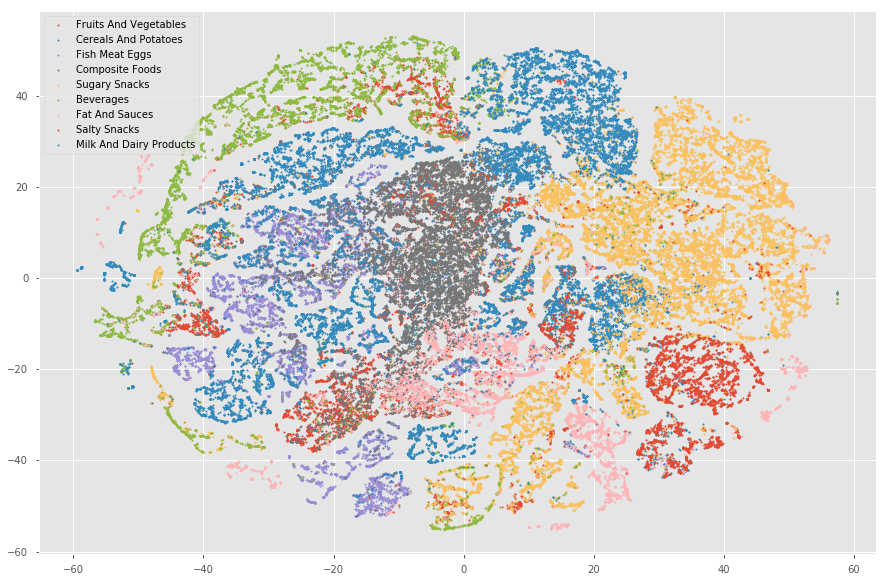

In [36]:
plt.figure(figsize = (15,10))
for name in data_nutri_pd.pnns_groups_1.unique():
        plt.scatter( 
            Y_tsne[y==name,0],\
            Y_tsne[y==name,1],\
            s = 2,\
            label=name
        )
plt.legend()
plt.show()


With the t-SNE plot we can observe much better clusters in the food categories. This implies our data can likely predict the category of the product in quite an accurate manner. We can also observe that some categories have multiple clusters: this can be expectable since some of them include completely different kind of products (let's think about 'Fat and Sauces', it can contain hypocaloric sauces vs very caloric fats).

We now define functions that let us plot the centroids of the different categories. It can be handy to visualize the distances in the categories for any pair of variables.

In [37]:
# compute center of each class
def compute_centroid(data, label):
    """data must be a 2D vector,label its category"""
    categories =np.unique(label)
    centroid = np.zeros((np.shape(categories)[0],2))
    category = np.zeros((np.shape(categories)[0],1), dtype = 'object')

    for i,name in enumerate(categories):
        centroid[i, :] = np.mean(data[label == name, :],axis = 0)
        category[i] = name
    return centroid, category


In [38]:
trace = go.Scattergl(
    x = Y_tsne[:,0],
    y = Y_tsne[:,1],
    mode = 'markers'
)
trace = []
for i,name in enumerate(data_nutri_pd.pnns_groups_1.unique()):
        trace.append(go.Scattergl( 
            x = Y_tsne[y==name,0],\
            y = Y_tsne[y==name,1],\
            name = name,\
            mode = 'markers',\
            text = product,\
            
            marker = dict(
                    size = 1.5,
                    line = dict(
                        width = 0.1)
            )
            )
                    )
centroids, categ = compute_centroid(Y_tsne,y)
trace.append(go.Scattergl(
    x = centroids[:,0],\
    y = centroids[:,1],\
    mode = 'markers',\
    text = categ,\
))
forplot = trace

# Plot and embed in ipython notebook!
py.iplot(forplot, filename='t-sne')

[Link to the plot](https://plot.ly/~eliBetta/14/fruits-and-vegetables-cereals-and-potatoes-fish-meat-eggs-composite-foods-sugary/)

In [39]:
def food_plot(data_centers, filename,title,xaxis,yaxis):
    range_x = [min(data_centers[:,0]) - 5, max(data_centers[:,0])+5]
    range_y = [min(data_centers[:,1]) - 5, max(data_centers[:,1])+5]
    
    layout= go.Layout(
            images=[dict(
                source= "https://raw.githubusercontent.com/mikelassi/Project/master/images/"+str(i)+".png",
                xref="paper",
                yref= "paper",
                x = (point[0] - (range_x[0]))/(range_x[1] - range_x[0]),
                y = (point[1] - (range_y[0]))/(range_y[1] - range_y[0]),
                sizex= 0.2,
                sizey= 0.2,
                xanchor= "center",
                yanchor= "middle"
              )  for i, point in enumerate(data_centers)]
            ,
            title = title,
            yaxis = dict(hoverformat='.3f', title=yaxis,range=range_y
     ),
            xaxis = dict(title=xaxis,range=range_x),
            showlegend=False,
            height = 500,
            width = 900

        )

    trace = go.Scatter(
        x = data_centers[:,0],\
        y = data_centers[:,1],\
        mode = 'markers',\
        text = categ,\
    )
    config={'StaticPlot': True}
    fig = go.Figure(data=[trace], layout=layout)
    return py.iplot(fig,filename = filename,config = config)
    

In [40]:
centroids, categ = compute_centroid(Y_tsne,y)
food_plot(centroids, 'centroid','Centroids of categories in t-sne space','1st component','2nd component')

[Link to the plot](https://plot.ly/~eliBetta/16/centroids-of-categories-in-t-sne-space/)

### d. Some more food plots

In [41]:
def combined_plot(data, feature_1, feature_2):
    X = data[[feature_1, feature_2]]
    y = data['pnns_groups_1']
    product = data['product_name']
    
    centroid, categ = compute_centroid(X.values, y)
    return food_plot(centroid, str(feature_1)+str(feature_2),'Centroids in '+str(feature_1) +' vs '+str(feature_2),str(feature_1),str(feature_2))

In [132]:

columns = ['salt_100g','proteins_100g','carbohydrates_100g','fat_100g','sugars_100g','energy_100g']
combi = list(itertools.combinations(columns, 2))

for i,combination in enumerate(combi):
    combined_plot(data_nutri_pd,combi[i][0],combi[i][1])

All the combinations of plots are saved on plotly. We will select the most interesting one for the data story.

### e. Classification of PNNS groups and nutrition grade

We now want to actually extend our categorization to products that miss it. At the same time we want to do the same for the nutritional grade. This score is available mostly only for French products, so it would be nice to extend it to other products, too. This will be the basis for our product advisor. We decided to train a Random Forest for its generalization capabilities. We use 10 estimators in the forest. We compute the F1-score as measure of performance. Since we are in a multiclass problem, we computed the micro-average of the F1 for each category.

In [42]:
data_nutri_pd = pd.read_pickle('data_nutri')

X=data_nutri_pd.iloc[:,1:7]
y=data_nutri_pd.iloc[:,0]#LABELS

#standardize values
X_std = StandardScaler().fit_transform(X)

split = train_test_split(X,train_size = 0.8, test_size = 0.2)
X_train = split[0]
X_test = split[1]

In [43]:
y_train = y[X_train.index]
y_test = y[X_test.index]

In [44]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

prediction = model.predict(X_test)
f1 = f1_score(y_test, prediction, average = 'micro')
confmat = confusion_matrix(y_test, prediction)

In [45]:
confmat

array([[1864,   15,    7,   20,    9,   65,  105,    2,   77],
       [  18, 2127,  123,    6,   23,   36,   31,   50,   75],
       [   5,  113, 2118,   62,  146,  106,   38,   17,   10],
       [  21,   17,   78, 1409,   14,   57,   17,   17,   40],
       [   3,   10,  133,   20, 1915,    6,   59,    3,    5],
       [ 100,   55,  117,   69,    5, 1340,   34,   13,   78],
       [  78,   27,   39,   30,  101,   36, 2772,    2,   64],
       [   0,   53,   31,   11,   12,    9,    2,  808,   37],
       [  42,   72,   12,   15,    6,   57,   85,   33, 4841]],
      dtype=int64)

In [46]:
print('The F1-score for food category classification is: '+ str(f1))

The F1-score for food category classification is: 0.8654522499774552


Based on the same idea we'd like to see if it's possible to classify all the products according the nutrition_grade_fr, in fact from the previuos analysis we saw that there is not that much difference for number of missing values among nutrition_score_fr_100f, nutrition_score_uk_100g and nutrition_grade_fr:

In [47]:
data_nutri_pd2.head(5)

,energy_100g,fat_100g,sugars_100g,proteins_100g,carbohydrates_100g,salt_100g,product_name,ingredients_from_palm_oil_n,nutrition_grade_fr
0,1594.0,22.0,21.9,4.6,27.3,0.100,Tarte noix de coco,0,d
1,657.0,0.0,27.0,0.6,36.0,0.000,Compote de poire,0,a
2,669.0,2.2,0.6,9.5,25.2,0.358,BAguette bressan,0,a
3,1059.0,17.0,0.5,23.0,0.5,2.500,Pavé de saumon fumé à la ficelle,0,d
4,2427.0,38.0,58.0,3.0,58.0,0.500,Stylo glaçage gris,0,e


In [48]:
data_nutri_pd2 = pd.read_pickle('data_nutri2')

X=data_nutri_pd2.iloc[:,0:6]
y=data_nutri_pd2.iloc[:,8]#LABELS

#standardize values
X_std = StandardScaler().fit_transform(X)

split = train_test_split(X,train_size = 0.8, test_size = 0.2)
X_train = split[0]
X_test = split[1]

y_train = y[X_train.index]
y_test = y[X_test.index]

In [49]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

prediction = model.predict(X_test)
f1 = f1_score(y_test, prediction, average = 'micro')
confmat = confusion_matrix(y_test, prediction)
confmat
#quite good results let's try to generalize to all the initial data set:


array([[3103,  399,  169,   42,   52],
       [ 576, 2500,  525,  109,   67],
       [ 151,  490, 3881,  756,  183],
       [  49,   89,  708, 6253,  567],
       [  72,   72,  231,  723, 4963]], dtype=int64)

In [50]:
print('The F1-score for food category classification is: '+ str(f1))

The F1-score for food category classification is: 0.7744107744107744


We get a lower, but overall good performance. From the confusion matrix we can observe that  most of the misclassifications happen between contiguous grades. Hence, the resulting misclassification is not drastically wrong.

Now that we have chosen our classifier for both the nutrition score and pnns category we can apply it to all the dataset (at least the one containing non-missing nutrition values). We will then create a new single dataframe on which we can compute our final score!

In [51]:
columns = ["energy_100g","fat_100g","sugars_100g",\
                       "proteins_100g","carbohydrates_100g",\
                       "salt_100g","product_name"]

nutrition_total = data.select(columns).toPandas()
nutrition_total = nutrition_total.dropna()

In [52]:
#train the classifiers for groups and score
model_groups = RandomForestClassifier()
model_score = RandomForestClassifier()

model_groups.fit(data_nutri_pd.iloc[:,1:7],\
                 data_nutri_pd.iloc[:,0].values.ravel())
model_score.fit(data_nutri_pd2.iloc[:,0:6],\
                data_nutri_pd2.iloc[:,8].values.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We also select the palm oil column, as we will need it for the final score. We assume that a null value in that column implies that no ingredients come from palm oil.

In [53]:
columns = ["energy_100g","fat_100g","sugars_100g",\
                       "proteins_100g","carbohydrates_100g",\
                       "salt_100g","product_name","ingredients_from_palm_oil_n"]


nutrition_without_group = data.select(columns).where((F.col('pnns_groups_1').isNull()) | (F.col('pnns_groups_1') == 'unknown')).toPandas()
nutrition_without_group['ingredients_from_palm_oil_n'] = nutrition_without_group['ingredients_from_palm_oil_n'].fillna(0)
nutrition_without_group = nutrition_without_group.dropna()

nutrition_without_score = data.select(columns).where(F.col('nutrition_grade_fr').isNull()).toPandas()
nutrition_without_score['ingredients_from_palm_oil_n'] = nutrition_without_score['ingredients_from_palm_oil_n'].fillna(0)
nutrition_without_score = nutrition_without_score.dropna()

In [54]:
prediction_group = model_groups.predict(nutrition_without_group.iloc[:,0:6])
prediction_score = model_score.predict(nutrition_without_score.iloc[:,0:6])

nutrition_without_group['pnns_groups_1'] = prediction_group
nutrition_without_score['nutrition_grade_fr'] = prediction_score

concatenated_group = pd.concat([nutrition_without_group, data_nutri_pd], sort=True)
concatenated_score = pd.concat([nutrition_without_score, data_nutri_pd2], sort=True)

concatenated_group = concatenated_group.drop_duplicates()
concatenated_score = concatenated_score.drop_duplicates()

complete_nutri = pd.merge(concatenated_group,concatenated_score, left_on = columns,right_on = columns, how='inner')
complete_nutri.head()

,carbohydrates_100g,energy_100g,fat_100g,ingredients_from_palm_oil_n,pnns_groups_1,product_name,proteins_100g,salt_100g,sugars_100g,nutrition_grade_fr
0,70.1,1569,7,0,Cereals And Potatoes,Vitória crackers,7.8,1.4,15,c
1,4.8,88,0,0,Fat And Sauces,Sauce Sweety chili 0%,0.2,2.04,0.4,c
2,5.3,134,0.3,0,Fruits And Vegetables,Salade de carottes râpées,0.9,0.42,3.9,a
3,16.3,540,4.9,0,Milk And Dairy Products,Fromage blanc aux myrtilles,4.4,0.25,16.3,c
4,38.4,929,3.3,0,Cereals And Potatoes,Baguette parisien,11.7,0.678,1.8,a


In [55]:
complete_nutri.to_pickle('complete_nutri')

We finally got our complete dataset! Yuppie :)

Now, we just need to add the palm oil data to compute our final advice score based on energy, palm oil and nutrition grade!

### f. Food advisor score
We compute a general advising score, that takes into account three health (and environment) parameters: the french nutrition grade (that gives up to 3.5 points), the energetic content (gives up to 1.5 points) and the palm oil content (up to 1 point). The scale will go from 1 to 6. We assign scores so that the distance between higher scores is less penalized than the distance between lower ones. 

In [56]:
complete_nutri = pd.read_pickle('complete_nutri')

In [57]:
dict_score = {'e':1,'d':2,'c':2.5,'b':3,'a':3.5}
dict_oil = {0:1,1:0.5,2:0.3,3:0}

def to_score(energy):
    minmax = 5000 # the maximum range of energy is from 0 to 5000
    return 1.5 - (energy) * 1.5 / minmax # the max score for energy is 1.5

We apply the same processing we used for the training data

In [58]:
complete_nutri.head()
numeric_columns = ['carbohydrates_100g','energy_100g','fat_100g',\
                   'ingredients_from_palm_oil_n','proteins_100g',\
                  'salt_100g','sugars_100g']

complete_nutri[numeric_columns] = complete_nutri[numeric_columns].apply(pd.to_numeric)
complete_nutri= filterData(complete_nutri,5000,100)

In [59]:
complete_nutri.head()

,carbohydrates_100g,energy_100g,fat_100g,ingredients_from_palm_oil_n,pnns_groups_1,product_name,proteins_100g,salt_100g,sugars_100g,nutrition_grade_fr
0,70.1,1569.0,7.0,0,Cereals And Potatoes,Vitória crackers,7.8,1.400,15.0,c
1,4.8,88.0,0.0,0,Fat And Sauces,Sauce Sweety chili 0%,0.2,2.040,0.4,c
2,5.3,134.0,0.3,0,Fruits And Vegetables,Salade de carottes râpées,0.9,0.420,3.9,a
3,16.3,540.0,4.9,0,Milk And Dairy Products,Fromage blanc aux myrtilles,4.4,0.250,16.3,c
4,38.4,929.0,3.3,0,Cereals And Potatoes,Baguette parisien,11.7,0.678,1.8,a


In [60]:
score_df = complete_nutri.copy()

score_df['energy_100g'] =score_df['energy_100g'].apply(to_score)
score_df['nutrition_grade_fr'] = score_df['nutrition_grade_fr'].replace(dict_score)
score_df['ingredients_from_palm_oil_n'] = score_df['ingredients_from_palm_oil_n'].replace(dict_oil)

We sum all the single scores together to get the final one!

In [61]:
score_df['total_score'] =  score_df['energy_100g'] +score_df['ingredients_from_palm_oil_n'] + score_df['nutrition_grade_fr']
final_score = score_df[['product_name','pnns_groups_1','total_score']]
final_score = final_score.sort_values(by='total_score',ascending = False)
final_score.to_pickle('final_score')

In [62]:
final_score.head()

,product_name,pnns_groups_1,total_score
385312,Limón Bio,Fruits And Vegetables,6.0
282553,10 steaks haches,Fish Meat Eggs,6.0
104368,"Lover's Tea, Herbs Tea",Sugary Snacks,6.0
245066,Ail Bulbe 200 Gélules - Nat Et Form - Atlantic ?,Composite Foods,6.0
157033,Les Nominettes pâtes nature,Cereals And Potatoes,6.0


Visualization of food score table on selection!

This table allows the user to see the first 20 best products of each category.

In [63]:
df = pd.read_pickle('final_score')

pnns = final_score.pnns_groups_1.unique()
trace = []
truth = np.eye(np.shape(pnns)[0],dtype =bool)

for i,categ in enumerate(pnns):
    trace.append(go.Table(
            header=dict(values=list(df.columns),
                        fill = dict(color='#C2D4FF'),

                        align = ['left'] * 3),
            visible = False,
            cells=dict(values= list(np.transpose(df[df['pnns_groups_1']==categ].iloc[0:19,:]).values),
                       fill = dict(color='#F5F8FF'),
                       align = ['left'] * 3)))


updatemenus = list([dict(buttons=list([{'label' :name, \
                                        'method' :'update',\
                                        'args': [{'visible':truth[i]}]}\
                                       for i,name in enumerate(pnns)]))])
                          



layout = dict(title='Best Products: please select a category!', showlegend=False,
              updatemenus=updatemenus)

fig = dict(data=trace, layout=layout)
       
py.iplot(fig, filename = 'score_table') 

[Link to table](https://plot.ly/~eliBetta/18/best-products-please-select-a-category/)

In [64]:
warnings.filterwarnings('ignore') #disable too many points warning

names = final_score.pnns_groups_1.unique()
trace =[]
for i,categ in enumerate(names):
    trace.append(go.Box(y = final_score[final_score['pnns_groups_1']==categ].total_score,name=categ))
layout = go.Layout(
    title = "Food score in each category")

fig = go.Figure(data = trace,layout=layout)
py.iplot(fig, filename = 'boxplot')



[Link to plot](https://plot.ly/~eliBetta/20/food-score-in-each-category/)

In [65]:
warnings.filterwarnings('always') #reactivate warnings

### g. Country analysis

In this part we investigate the nutrition score of the products in the whole dataset and with respect to each brand. 

In [66]:
data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in ['brands']]).show()

+------+
|brands|
+------+
|224276|
+------+



There are 224,276 products over the 685,395 without any brand tag. We remove them, assuming the statistics does not change (very low number). We also remove the products with a null 'countries_en' tag. 

In [67]:
data_brands_countries = data.na.drop(subset=['brands', 'countries_en'])

In [68]:
data_brands_countries.count()

460800

There are 460,800 products with a non-null 'brands' tag and non-null 'countries_en' tag (=country in which the product is sold).

In [73]:
# we extract the products sold both in the United States and in France.
data_us_and_fr = data_brands_countries.rdd.filter(lambda r: re.match('(?=.*united State)(?=.*france)', r['countries_en'], flags=re.IGNORECASE)).toDF(schema=data.schema)
count = data_us_and_fr.groupby('brands').count()

In [74]:
print("There are", count.count(), "brands present both in the US and in France.")

There are 1107 brands present both in the US and in France.


In [75]:
# here is the products sold both in the US and in France. There are mainly american brands. 
count.orderBy('count',ascending=False).show()

+--------------------+-----+
|              brands|count|
+--------------------+-----+
|        Trader Joe's|   27|
|         Lee Kum Kee|   13|
|       Nature's Path|   12|
|              Skippy|   10|
|           Kellogg's|    9|
|         Great Value|    8|
|Arizona,  Ferolit...|    8|
|Foco,  Thai Agri ...|    8|
|               Kraft|    7|
|                Kind|    6|
|           Hershey's|    6|
|                Foco|    6|
|     Pepperidge Farm|    6|
|     Lenny & Larry's|    6|
|  Kirkland Signature|    6|
|  365 Everyday Value|    5|
|       Crystal Light|    5|
|                 S&B|    5|
|       Nature Valley|    5|
|              Auchan|    5|
+--------------------+-----+
only showing top 20 rows



In the present dataset there are a very few brands sold both in the United States and in France. 

In [76]:
# here we extract the product sold only in the United States.
data_us_only = data_brands_countries.select('brands', 
            'countries_en',
            'nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk') \
.filter("countries_en=='United States'")

In [77]:
# here we see if there are non-null nutrition scores for a large enough number of products.
data_us_only.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in \
           ['nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk']]).show()

+-----------------------+-----------------------+------------------+------------------+
|nutrition-score-fr_100g|nutrition-score-uk_100g|nutrition_grade_fr|nutrition_grade_uk|
+-----------------------+-----------------------+------------------+------------------+
|                 169380|                 169380|            169380|            171384|
+-----------------------+-----------------------+------------------+------------------+



In [78]:
print("number of products sold in the US with a non-null nutrition score:", N_us.values[1] - 171513)
print("ratio among the total number of products sold in the US:", (N_us.values[1] - 171513)/N_us.values[1]*100)

number of products sold in the US with a non-null nutrition score: 1982
ratio among the total number of products sold in the US: 1.142396034467852


Only 1982 products sold in the United States have a nutrition score... We cannot do a statistically significant nutrition analysis on the set of products sold in the US when only 1.14% of the product are annotated with a nutrition score.

In [79]:
# here we extract the products sold only in France.
data_fr_only = data_brands_countries.select('brands', 
            'countries_en',
            'nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk') \
.filter("countries_en=='France'")

In [80]:
# number of products sold only in France.
data_fr_only.count()

217393

In [81]:
# here we see if there are non-null nutrition scores for a large enough number of products.
data_fr_only.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in \
           ['nutrition-score-fr_100g',
            'nutrition-score-uk_100g',
            'nutrition_grade_fr',
            'nutrition_grade_uk']]).show()

+-----------------------+-----------------------+------------------+------------------+
|nutrition-score-fr_100g|nutrition-score-uk_100g|nutrition_grade_fr|nutrition_grade_uk|
+-----------------------+-----------------------+------------------+------------------+
|                 116825|                 116825|            116825|            217393|
+-----------------------+-----------------------+------------------+------------------+



Among the 217,393 products sold in France with a non-null brand there are 101,289 (=218,114 -116,825) products with a nutrition score. We are going to focus the analysis "nutrition vs brand" on the products sold only in France and using the french nutrition grade.   

## 2) Analysis of the french market

## A. Health analysis via the nutri-score

### a. load and clean

In [82]:
# extract the products only sold in France
# get the features of interest ('brands,','nutrition_grade_fr' and 'pnns_groups_1')
bra_cat_nut = data.filter("countries_en=='France'")\
                    .select('brands', 'nutrition_grade_fr', 'pnns_groups_1')\
                    .dropna(how='all')

In [83]:
# clean the column 'pnns_groups_1' as done before to end with consistent category names.
bra_cat_nut = bra_cat_nut.withColumn('pnns_groups_1',(F.regexp_replace('pnns_groups_1', '-', ' ')))
square_udf_int = F.udf(lambda z: z.title() if z else z)
bra_cat_nut = bra_cat_nut.withColumn('pnns_groups_1',square_udf_int('pnns_groups_1'))

In [84]:
# we convert the spark dataframe to a pandas dataframe
bra_cat_nut_df = bra_cat_nut.toPandas()

# we store it in the current folder 
bra_cat_nut_df.to_pickle('bra_cat_nut_df')

C:\Users\micha\Anaconda3\lib\socket.py:657: ResourceWarning:

unclosed <socket.socket fd=3092, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 49869), raddr=('127.0.0.1', 49845)>



In [85]:
# we can now read it everytime we want to continue the analysis
bra_cat_nut_raw_df = pd.read_pickle('bra_cat_nut_raw_df')

In [86]:
bra_cat_nut_raw_df.head(3)

,brands,nutrition_grade_fr,pnns_groups_1
0,CROUS,None,Unknown
1,"Crous Resto',Crous",d,Unknown
2,Ferme De La Frémondière,None,Unknown


- We create a dictonary of parent brand to replace a brand by its "parent brand" when it belongs to a bigger one
For example 'Bio Village' is a brand of Leclerc which owes also 'Marque Repère' then we can replace 'Bio Village' and 'Marque Repère' by 'Leclerc'. We will to analysis the food sold by the company Leclerc.


- Moreover, we set to None the brand when it is "Sans Marque". "Sans Marque" means the brand had not been specified by the user: it can be "Marque Repère", "Carrefour", "Délisse" ect.To understand the 'Sans Marque' products we checked them using the product search tool on https://fr.openfoodfacts.org with the tag "Sans Marque".

In [87]:
# list of food brands present in France ('Coca Cola', 'Fleury Michon', 'Carrefour' ect.)
list_brand_file = open("brand_list.txt", "r")
list_brand = list_brand_file.read().split('\n')

# dictonary of parent brands. 
dict_parent_brand= {'Bio Village': 'Leclerc',
                    'Marque Repère': 'Leclerc',
                    'Sans Marque': None}

The problem is that the 'brands' tags are not always consistent. For example we can find the brand tag 'carrefour', "Carrefour", "carrfour,bio carrefour' ect. 
Hence we first clean the brands using a list of food brands present in France and a function to match the 'brands' tag with the closest brand in the list. 

In [88]:
# Function which finds for each value (string) in the column 'brands' the closest brand (string) in 'list_brand'.
# Note: the function 'get_close_matches' has been imported from the open-source 'difflib' library.
def clean_brand(brand_name):
    
    # brand name can be of the form 'Carrefour' (one word) or 'Carrefour, Bio Carrefour' (multiple words)
    # hence we split the string w.r.t the symbol ',' and find the best matching brand word for each split.
    matches=[]
    if brand_name:
        
        for word in brand_name.split(','):

            # the cutoff control for the False Positives possibilities in the 'list_brand' 
            # that don’t score at least the cutoff are ignored.
            # the parameter 'n' controls for the the number of possibilities (whose score is higher than the cutoff value).
            matches.append(get_close_matches(word.lower(), list_brand, n=1, cutoff=0.6))

        # remove empty sublists and unravel
        matches = [brand for sublist in matches for brand in sublist if sublist]
        
        # output brand
        if matches:
            output = matches[0]
        else:
            output = None
                
        # check for parent brand
        if output in dict_parent_brand:
            output = dict_parent_brand[output]
        
        return output

In [89]:
# we create a new column with the new "consistent" brand tag. 
# takes some minutes to run...
bra_cat_nut_raw_df['new_brands'] = bra_cat_nut_raw_df['brands'].apply(lambda x: clean_brand(x))

In [90]:
# drop when both 'nutrition_grade_fr' and 'brands' are None
bra_cat_nut_cleaned_df = bra_cat_nut_raw_df.dropna(subset=['nutrition_grade_fr', 'brands'], how='all') 

# we can drop the old column 'brands' since we have the new ones.
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.drop('brands',1).rename(columns={'new_brands':'brands'})

bra_cat_nut_cleaned_df.head()

,nutrition_grade_fr,pnns_groups_1,brands
0,None,Unknown,Crous
1,d,Unknown,Crous
2,None,Unknown,None
3,a,Fruits And Vegetables,Crous
4,None,Unknown,None


In [91]:
# here we count the number of products for each brand. 
count = bra_cat_nut_cleaned_df.groupby('brands').count().sort_values('nutrition_grade_fr', ascending=False)

In [92]:
# we consider that brand can be analysed if at least 100 products in the dataset belong to this brand.
count['enough_products']= count[['nutrition_grade_fr']].apply(lambda x: x>100)
count = count[count.enough_products]
count.head()

,nutrition_grade_fr,pnns_groups_1,enough_products
brands,,,
Carrefour,3643,5818,True
Auchan,3594,5679,True
Leclerc,2308,3746,True
Casino,2191,3418,True
Leader Price,2145,3117,True


The most abundant brands are Carrefour, Auchan and U. There are the brands of the biggest distributors (supermarkets) in France. 

In [94]:
# here we add the column "enough products" to the dataframe with the cleaned brand.
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.join(count[['enough_products']], on='brands')
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.drop('enough_products',1)
bra_cat_nut_cleaned_df.head()

,nutrition_grade_fr,pnns_groups_1,brands
0,None,Unknown,Crous
1,d,Unknown,Crous
2,None,Unknown,None
3,a,Fruits And Vegetables,Crous
4,None,Unknown,None


The nutrition score in 'nutrition_grade_fr' is the Nutri-Score developped by the french governement and based on the components present in the food (sugar, fiber, fat ect.). You can find more information at https://fr.wikipedia.org/wiki/Nutri-score.

- 'a' (very good product for health) 
- 'b' (good product)
- 'c' ('neutral product')
- 'd' ('not so good product')
- 'e' (bad product for health)

In [95]:
# here we create dummy variables from the 'nutrition_grade_fr'.
bra_cat_nut_cleaned_expanded_df = pd.get_dummies(bra_cat_nut_cleaned_df.set_index('brands')).reset_index()
bra_cat_nut_cleaned_dummies_df = bra_cat_nut_cleaned_expanded_df.rename(columns=
                              {'nutrition_grade_fr_a':'a',
                               'nutrition_grade_fr_b':'b',
                               'nutrition_grade_fr_c':'c',
                               'nutrition_grade_fr_d':'d',
                               'nutrition_grade_fr_e':'e',
                               'pnns_groups_1_Beverages': 'Beverages',
                               'pnns_groups_1_Cereals And Potatoes':'Cereals And Potatoes',
                               'pnns_groups_1_Composite Foods': 'Composite Foods',
                               'pnns_groups_1_Fat And Sauces':'Fat And Sauces',
                               'pnns_groups_1_Fish Meat Eggs':'Fish Meat Eggs',
                               'pnns_groups_1_Fruits And Vegetables':'Fruits And Vegetables',
                               'pnns_groups_1_Milk And Dairy Products':'Milk And Dairy Products',
                               'pnns_groups_1_Salty Snacks':'Salty Snacks',
                               'pnns_groups_1_Sugary Snacks':'Sugary Snacks',
                               'pnns_groups_1_Unknown': 'Unknown'})
bra_cat_nut_cleaned_dummies_df.head(5)

,brands,a,b,c,d,e,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown
0,Crous,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Crous,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Crous,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [96]:
# we store it in the current Notebook folder 
bra_cat_nut_cleaned_df.to_pickle('bra_cat_nut_cleaned_df')
bra_cat_nut_cleaned_dummies_df.to_pickle('bra_cat_nut_cleaned_dummies_df')

### b. Load cleaned data

In [97]:
# instead recomputing the cleaning step everytime...
bra_cat_nut_df = pd.read_pickle('bra_cat_nut_cleaned_df')
bra_cat_nut_dummies_df = pd.read_pickle('bra_cat_nut_cleaned_dummies_df')

### c. Food quality in France

In [98]:
# here we count the number of products inside each nutrition category (5 categories from 'a' to 'e')
count = pd.DataFrame(data=bra_cat_nut_dummies_df[['a','b','c','d','e']].sum(), columns=['count'])
count.index.name = 'nutrition_grade_fr'

In [99]:
# we convert count into ratio (regarding the total number of products)
number_of_products = bra_cat_nut_df.nutrition_grade_fr.count()
print("Total number of products sold in France:", number_of_products)

ratio = count.div(number_of_products).multiply(100).rename(columns={'count':'ratio'})
ratio.head(3)

Total number of products sold in France: 103571


,ratio
nutrition_grade_fr,
a,13.111778
b,13.764471
c,20.704637


In [100]:
# interactive plot
data = []
colors = sns.color_palette("RdBu_r", 5).as_hex()

for index, row in ratio.reset_index().iterrows():
    data.append(go.Bar(x=np.array(index),
                       y=np.array(row['ratio']),
                       name = row['nutrition_grade_fr'],
                       marker={'color': colors[index]}))

layout = go.Layout(
    title='Nutri-Score repartition in France.',
    xaxis=go.layout.XAxis(
        title='Nutriscore',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(5).astype(str),
        ticktext=ratio.index,
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
fig

FigureWidget({
    'data': [{'marker': {'color': '#3783bb'},
              'name': 'a',
              'type': …

[link to the figure](http://plot.ly/~tomM/94.embed)

In [102]:
# interactive plot
labels = count.index
values = count['count'].values
colors = sns.color_palette("RdBu_r", 5).as_hex()

fig = {
    'data': [{'labels': labels,
              'values': values,
              'type': 'pie',
              'marker':{'colors':colors}
              }
            ],
    'layout': {'title': 'Nutri-Score repartition in France.'}
     }

py.iplot(fig, filename='food_quality_in_france_pie', auto_open=False)

[link to the figure](http://plot.ly/~tomM/96.embed)

We can observe than, unfortunalty, more than 50% of the products sold in France have a bad nutrition grade (d or e). 
The healthy product tagged with the grade 'a' only represent 13% of the ~100,000 products in the data set.

### d. Food quality for each french food brand

In [7]:
# read the data
bra_nut_df = bra_cat_nut_df[['brands', 'nutrition_grade_fr']]
bra_nut_dummies_df = bra_cat_nut_dummies_df[['brands','a','b','c','d','e']]

In [8]:
# extract the total number of products for each brands
brand_count = bra_nut_df.groupby('brands').count().rename(columns={'nutrition_grade_fr':'total'})

In [9]:
# count the nutrition grade occurences for each brand
brand_dummies_count = bra_nut_dummies_df.groupby('brands').sum()

In [10]:
# we add the column 'total' to further extract the ratio of each grade instead of the raw count.
brand_dummies_count = brand_dummies_count.join(brand_count)
brand_dummies_count.head()

,a,b,c,d,e,total
brands,,,,,,
123 bio,121.0,75.0,54.0,91.0,80.0,421
7Up,0.0,5.0,1.0,4.0,24.0,34
A l'olivier,0.0,2.0,19.0,43.0,3.0,67
Ajax,1.0,0.0,0.0,0.0,1.0,2
Albert Menes,2.0,6.0,27.0,37.0,22.0,94


In [11]:
# we convert the counts into ratios. 
# ex: ratio for 'a' = (count for 'a') / (total number of products)
brand_nutri_ratio = brand_dummies_count.copy()
brand_nutri_ratio[['a','b','c','d','e']] = brand_dummies_count[['a','b','c','d','e']].div(brand_dummies_count['total'].values,axis=0)*100
brand_nutri_ratio = brand_nutri_ratio.sort_values('total',ascending=False)

In [12]:
# extract the 10 biggest brands
ratio_top10 = brand_nutri_ratio.reset_index().loc[:9].drop('total',1)

# save the brand names for further analysis 
top10_brand_names = ratio_top10.brands.values

ratio_top10.head()

,brands,a,b,c,d,e
0,Carrefour,19.763931,15.344496,19.818831,26.269558,18.803184
1,Auchan,18.391764,15.303283,21.313300,26.794658,18.196995
2,Leclerc,13.648180,15.901213,22.010399,27.816291,20.623917
3,Casino,18.849840,15.609311,20.903697,25.604747,19.032405
4,Leader Price,17.482517,13.939394,22.750583,26.293706,19.533800


In [13]:
# interactive plot
data = []
colors = sns.color_palette("tab10", ratio_top10.brands.count()).as_hex()

for index, row in ratio_top10.iterrows():
    data.append(go.Bar(x=['a','b','c','d','e'],
                       y=np.array(row[1:]),
                       name = row['brands'],
                       marker={'color': colors[index]}))

layout = go.Layout(
    title='Nutrition score occurences for the 10 biggest food brands in France.',
    xaxis=go.layout.XAxis(
        title='Nutriscore',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(5).astype(str),
        ticktext=['a','b','c','d','e'],
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='brands_vs_nutriscore_bar', auto_open=False)

[link to the figure](http://plot.ly/~tomM/106.embed)

In [14]:
# interactive plot
data = []
colors = sns.color_palette("RdBu_r", 5).as_hex()

for index in range(len(['a','b','c','d','e'])):
    data.append(go.Bar(x=ratio_top10['brands'],
                       y=ratio_top10[ratio_top10.columns[index+1]],
                       name = ratio_top10.columns[index+1],
                       marker={'color': colors[index]}))

layout = go.Layout(
    
    title='Nutrition score distribution within the 10 biggest food brands in France.',
    barmode='stack',
    
    # x axis
    xaxis=go.layout.XAxis(
        title='Food Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(10).astype(str),
        ticktext=ratio_top10['brands'],
    ),
    
    # y axis
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        showgrid=True,
        gridcolor='#bdbdbd',
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='brands_vs_nutriscore_bar_stacked', auto_open=False)

[link to the figure](http://plot.ly/~tomM/103.embed)

As seen previously, we observe that for almost all the biggest food brands present in France more than 40% of the products are "junk" food (products with labels 'e' or 'd'). We don't eat that well in France... 

The exception is 'Picard' in which products tagged with 'd' or 'e' represent one third of the total number of products (which is already quite high...). Actually, Picard mainly sells frozen food which could be excpected to be healthier than the products sold by Netto (cheap product mainly industrial).

### e. Category Distribution in the 10 biggest food brands in France. 

In [65]:
# read the data
bra_cat_df = bra_cat_nut_df[['brands', 'pnns_groups_1']]
bra_cat_dummies_df = bra_cat_nut_dummies_df.drop(['a','b','c','d','e'], axis=1)

In [66]:
# here we count the category occurences for each brand
brand_dummies_count = bra_cat_dummies_df.groupby('brands').sum()

# we add the column total to further extract the ratio of each grade instead of the raw count
brand_count = pd.DataFrame(data=brand_dummies_count.sum(axis=1), columns=['total'])
brand_dummies_count = brand_dummies_count.join(brand_count)

brand_dummies_count.head(3)

,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown,total
brands,,,,,,,,,,,
123 bio,38.0,60.0,28.0,38.0,28.0,64.0,43.0,15.0,72.0,222.0,608.0
7Up,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,37.0
A l'olivier,0.0,1.0,2.0,41.0,1.0,0.0,0.0,0.0,2.0,67.0,114.0


In [67]:
# we focus on the 10 biggest brands
ratio_bra_cat = brand_dummies_count.copy().reset_index()
ratio_bra_cat = ratio_bra_cat[ratio_bra_cat['brands'].isin(top10_brand_names)].set_index('brands')

In [68]:
# we convert the counts into ratios
ratio_bra_cat.iloc[:, np.arange(10)] = brand_dummies_count.iloc[:,np.arange(10)].div(brand_dummies_count['total'].values,axis=0)*100

In [69]:
ratio_bra_cat.sort_values(by='Unknown')

,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown,total
brands,,,,,,,,,,,
Belle France,6.370795,7.229778,11.739442,5.941303,9.949893,9.305655,13.815319,4.509664,15.175376,15.962777,1397.0
Picard,0.539568,2.637890,37.170264,1.738609,9.472422,10.071942,8.932854,2.218225,8.992806,18.225420,1668.0
Monoprix,5.847953,8.878256,11.483254,4.731526,9.941520,7.921318,9.994684,3.030303,12.706007,25.465178,1881.0
Leader Price,5.774783,6.256015,11.004171,4.202759,8.020533,6.127687,10.137953,2.983638,10.619185,34.873276,3117.0
Carrefour,4.881403,8.078377,8.525266,4.331385,8.765899,7.356480,7.751805,2.543829,10.244070,37.521485,5818.0
Leclerc,6.940737,7.234383,8.622531,2.162306,8.649226,5.125467,7.020822,1.067806,14.281901,38.894821,3746.0
Casino,6.231714,7.050907,9.215916,3.832651,6.495026,6.143944,7.665301,2.837917,10.269163,40.257461,3418.0
Auchan,5.265011,6.374362,8.681106,4.824793,8.188061,6.691319,8.874802,2.201092,7.941539,40.957915,5679.0
Cora,6.791467,4.658250,7.792773,4.309970,8.663474,6.704397,6.269047,3.439269,10.317806,41.053548,2297.0


We chose to remove the category Unknown since it gathers products from multiple categories. It is not relevant to analyze the distribution of products tagged 'Unknown' since they don't represent any real category of products. The user just omitted to tag the category. 

In [70]:
ratio_to_plot = ratio_bra_cat.reset_index().drop(['total', 'Unknown'],1)

In [71]:
# interactive plot
data = []
colors = sns.color_palette("tab10", ratio_to_plot.brands.count()).as_hex()

for index, nutri in enumerate(ratio_to_plot.columns[1:]):
    data.append(go.Bar(x=ratio_to_plot['brands'],
                       y=ratio_to_plot[ratio_to_plot.columns[index+1]],
                       name = ratio_to_plot.columns[index+1],
                       marker={'color': colors[index]}))

layout = go.Layout(
    title='Food Category distribution within the 10 biggest food brands in France.',
    xaxis=go.layout.XAxis(
        title='Food Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(10).astype(str),
        ticktext=ratio_to_plot['brands'],
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='category_vs_brand_bar', auto_open=False)

[link to the figure](http://plot.ly/~tomM/120.embed)

In [73]:
# interactive plot
data = []
colors = sns.color_palette("tab10", len(ratio_to_plot.columns[1:])).as_hex()

for index, nutri in enumerate(ratio_to_plot.columns[1:]):
    data.append(go.Scatter(x=ratio_to_plot['brands'],
                       y=ratio_to_plot[ratio_to_plot.columns[index+1]],
                       name = ratio_to_plot.columns[index+1],
                       marker={'color': colors[index]}
                          )
               )
    
fig = tools.make_subplots(rows=3, cols=3, subplot_titles=tuple(ratio_to_plot.columns[1:]))

for index,trace in enumerate(data):
    (r, c) = divmod(index, 3)
    fig.append_trace(trace, r+1, c+1)

fig['layout']['yaxis1'].update(title='Ratio (in %)')
fig['layout']['yaxis4'].update(title='Ratio (in %)')
fig['layout']['yaxis7'].update(title='Ratio (in %)')

fig['layout'].update(title='Food Category distribution within the 10 biggest food brands in France.', height=900, width=1000)

py.iplot(fig, filename='category_vs_brand_subplots', auto_open=False)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



[link to the figure](http://plot.ly/~tomM/122.embed)

The analysis is hard since for all the brands except 'Picard' and 'Belle France' the products whose category is 'Unknown' represent more than 1/4 of the total number of products of the brand. For 'Picard' and 'Belle France' more than 80% of the products have a relevant tag 'categroy' (e.g 'Beverages'). We stick the analysis to those two brands:   

- we osberve that the brand 'Picard' mainly sells 'Composite food' which is frozen food, which are mainly tagged 'a'. Picard can be called a "healthy brand". 


- on the opposite the brand 'Belle France' has a high ratio (15%) of products tagged 'Sugary Snacks'. It is the most unhealthy food category with a large majority of products tagged 'e' or 'd' regarding their nutrition grade. 'Belle France' sells a lot of "junk" food. However, the food category ratios are more homogeneous than the ones of the brand 'Picard'.      


### f. Nutrition grade repartition per category in France

In [25]:
# read the data 
cat_nut_df = bra_cat_nut_df[['pnns_groups_1', 'nutrition_grade_fr']]

In [26]:
# number of products (total)
cat_nut_df.index[-1]

223388

In [27]:
# we drop the null value
cat_nut_df = cat_nut_df.dropna()

In [28]:
# number of products (after removing the null)
cat_nut_df.reset_index(drop=True).index[-1]

103469

We removed half the products but having still more than 100,000 products we assume the analysis is still statistically significant.

In [29]:
# we get dummies from the nutrition grades
cat_nut_df = pd.get_dummies(cat_nut_df.set_index('pnns_groups_1')).rename(columns=
                              {'nutrition_grade_fr_a':'a',
                               'nutrition_grade_fr_b':'b',
                               'nutrition_grade_fr_c':'c',
                               'nutrition_grade_fr_d':'d',
                               'nutrition_grade_fr_e':'e'})

In [30]:
# we count the number of products with grade 'a','b' ect. for each food category
count = cat_nut_df.groupby('pnns_groups_1').sum()
count['total'] = count.apply(lambda x: x['a']+x['b']+x['c']+x['d']+x['e'], axis=1) 
count.head(3)

,a,b,c,d,e,total
pnns_groups_1,,,,,,
Beverages,71.0,854.0,1812.0,1624.0,3754.0,8115.0
Cereals And Potatoes,3839.0,1630.0,1616.0,1045.0,101.0,8231.0
Composite Foods,1798.0,3407.0,3404.0,2073.0,185.0,10867.0


In [31]:
# we extract ratio from the counts and the total number of products for each category
ratio = count.copy()
ratio[['a','b','c','d','e']] = count[['a','b','c','d','e']].div(count['total'].values,axis=0)*100
ratio.head(3)

,a,b,c,d,e,total
pnns_groups_1,,,,,,
Beverages,0.874923,10.523722,22.329020,20.012323,46.260012,8115.0
Cereals And Potatoes,46.640748,19.803183,19.633094,12.695906,1.227068,8231.0
Composite Foods,16.545505,31.351799,31.324193,19.076102,1.702402,10867.0


In [32]:
# we remove the 'total' column and we sort the category w.r.t to the ratio for the score 'a' (the healthier)
ratio_to_plot = ratio.reset_index().drop('total',1).sort_values(by=['a'],ascending=0)

# drop 'Unknown' category since not relevant for analysis (regroup multiple categories of products)
ratio_to_plot = ratio_to_plot[ratio_to_plot.pnns_groups_1 != 'Unknown'].reset_index(drop=True)

In [33]:
# interative plot
data = []
colors = sns.color_palette("RdBu_r", 5).as_hex()

for index, nutri in enumerate(ratio_to_plot.columns[1:]):
    data.append(go.Bar(x=ratio_to_plot['pnns_groups_1'],
                       y=ratio_to_plot[ratio_to_plot.columns[index+1]],
                       name = ratio_to_plot.columns[index+1],
                       marker={'color': colors[index]}))

layout = go.Layout(
    barmode='stack',
    title='Health profile for each food category.',
    xaxis=go.layout.XAxis(
        title='Food Category',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickangle = 20,
        tickvals=np.arange(10).astype(str),
        ticktext=ratio_to_plot['pnns_groups_1'],
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)

py.iplot(fig, filename='food_category_vs_nutriscore', auto_open=False)

[link to the figure](http://plot.ly/~tomM/98.embed)

As excepted we can obsevrve than the most healthy products are fruits and vegetables... And that the worst are snacks and beverages. 

Interestingly, the sugary snacks are worst for health than the salty snacks or the fatty products. Indeed the ratio of 'e' products is 49% for sugary snacks and 14% for salty snacks or 22% for fat and sauces. Moreover, the sum of 'e'+'d' ratios is also higher for sugary snacks. This could demonstrate that the real ennemy is maybe more 'sugar' than 'salt' or 'fat' which contrast with the standard nutritional recommendations which usually emphasize on fat.

Finally the most heterogeneous category is the 'Fish Meat Eggs' one. It probably contains good products like fish without any industrial transformation and bad products like breaded fish or bacon.

### g. Score each brand from nutrition score ratios

In [34]:
brand_nutri_ratio.head(3)

,a,b,c,d,e,total
brands,,,,,,
Carrefour,19.763931,15.344496,19.818831,26.269558,18.803184,3643
Auchan,18.391764,15.303283,21.313300,26.794658,18.196995,3594
Leclerc,13.648180,15.901213,22.010399,27.816291,20.623917,2308


In [35]:
# keep only the brand which have more than 100 products
brand_nutri_ratio = brand_nutri_ratio[brand_nutri_ratio.total > 100]

In [36]:
# we will assign a score to each brand. The best score is 5 (for 'a') and the worst is 1 ('e'). 
scores = np.array([5,4,3,2,1])

# for each brand the score will be the average of the ratios in each category ('a','b'..) weighted by the score of each category (5,4..) 
brand_score_nutri = brand_nutri_ratio.drop('total', axis=1).multiply(1/100).multiply(scores).mean(axis=1).to_frame(name='nutrition score')
brand_score_nutri['nutrition score'] *= 5
brand_score_nutri.sort_values(by='nutrition score', ascending=False, inplace=True)

A score of 5 for a brand means that 100% of the products sold by the brand are 'a' (very healthy). 

In [37]:
# take the 10 best (highest score) and 10 worst brand (lowest score)
brand_10best_10worst = pd.concat([brand_score_nutri.head(10).reset_index(), brand_score_nutri.tail(10).reset_index()], axis=0).reset_index(drop=True)

In [38]:
# interactive plot
data = []
colors = sns.color_palette("RdBu_r", 20).as_hex()
y_values = ['a','b','c','d','e']

for index, row in brand_10best_10worst.iterrows():
    data.append(go.Bar(x=np.array(index),
                       y=np.array(row['nutrition score']),
                       name = row['brands'],
                       marker={'color': colors[index]}))

layout = go.Layout(
    showlegend=False,
    title='Health score of the 10 best and 10 worst food brands in France.',
    xaxis=go.layout.XAxis(
        title='Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(20).astype(str),
        ticktext=brand_10best_10worst.brands.values,
    ),
    yaxis=dict(
        title='Global Nutrition Score',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        showgrid = True,
        gridcolor='#bdbdbd',
        range=[0, 6],
        tickwidth=3,
        tickvals=np.arange(1,6).astype(str),
        ticktext=y_values[::-1],
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='mean_nutriscore_vs_brand', auto_open=False)

[link to the figure](http://plot.ly/~tomM/114.embed)

From this bar plot we can the best and the worst brands for health. 

- As we could expect, eating chocolate is not good... But, suprisingly the 6 worst brands are all chocolate ones except Monin which sell sirop. 

- The best brands are 'D'Aucy' - which sells a lot of vegetables and fruits in cans - and 'Charles et Alice' - which sells fruits in cup.  

## B. Palm Oil analysis in France

### a. load and clean

In [ ]:
# we filter the spark dataframe for products sold in France only 
# we extract the two columns tagging for palm oil presence
bra_palm_raw = data.filter("countries_en=='France'")\
                    .select('brands', 'ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n')\
                    .dropna(how='all')

In [ ]:
# we convert the spark dataframe to a pandas dataframe
bra_palm_raw_df = bra_palm.toPandas()

# we store it in the current folder 
bra_palm_raw_df.to_pickle('bra_palm_raw_df')

In [ ]:
# read the stored dataframe
bra_palm_raw_df = pd.read_pickle('bra_palm_raw_df')

In [ ]:
bra_palm_raw_df.head(3)

In [ ]:
bra_palm_raw_df['new_brands'] = bra_palm_raw_df['brands'].apply(lambda x: clean_brand(x))

In [ ]:
# drop when both 'ingredients_from_palm_oil_n' and 'ingredients_that_may_be_from_palm_oil_n' are None
bra_palm_cleaned_df = bra_palm_raw_df.dropna(subset=['ingredients_from_palm_oil_n', \
                                                 'ingredients_that_may_be_from_palm_oil_n'], how='all') 

In [ ]:
# we can drop the old column 'brands' since we have the new ones.
bra_palm_cleaned_df = bra_palm_cleaned_df.drop('brands',1).rename(columns={'new_brands':'brands'})

# reset the index
bra_palm_cleaned_df = bra_palm_cleaned_df.reset_index(drop=True)

In [ ]:
# convert into numeric values
bra_palm_cleaned_df['ingredients_from_palm_oil_n'] = bra_palm_cleaned_df['ingredients_from_palm_oil_n'].apply(pd.to_numeric)
bra_palm_cleaned_df['ingredients_that_may_be_from_palm_oil_n'] = bra_palm_cleaned_df['ingredients_that_may_be_from_palm_oil_n'].apply(pd.to_numeric)

In [ ]:
# save to pickle
bra_palm_cleaned_df.to_pickle('bra_palm_cleaned_df')

### b. Load cleaned data

In [84]:
bra_palm_df = pd.read_pickle('bra_palm_cleaned_df')

### c. Palm oil presence in the whole french market

In [85]:
bra_palm_bool_df = bra_palm_df.copy()
bra_palm_bool_df.iloc[:,0] = bra_palm_bool_df.iloc[:,0].apply(lambda x: x>0) # for 'ingredients_from_palm_oil_n'
bra_palm_bool_df.iloc[:,1] = bra_palm_bool_df.iloc[:,1].apply(lambda x: x>0) # for 'ingredients_that_may_be_from_palm_oil_n'

In [86]:
bra_palm_to_plot_df = bra_palm_df[['brands']].copy()
bra_palm_to_plot_df['no_palm_oil'] = bra_palm_bool_df.apply(lambda x: 1 if not x[0] and not x[1] else 0, axis=1) 
bra_palm_to_plot_df['may_contain_palm_oil'] = bra_palm_bool_df.apply(lambda x: 1 if x[0] and not x[1] else 0 , axis=1) 
bra_palm_to_plot_df['contain_palm_oil'] = bra_palm_bool_df.apply(lambda x: 1 if x[1] else 0, axis=1) 

In [87]:
bra_palm_to_plot_df.head(3)

,brands,no_palm_oil,may_contain_palm_oil,contain_palm_oil
0,Crous,1,0,0
1,None,1,0,0
2,None,1,0,0


In [88]:
# count the number of product for each palm category 
count = bra_palm_to_plot_df.sum(axis=0)

In [89]:
# interactive plot
data = []
colors = sns.color_palette("Reds", 3).as_hex()
labels = ['no palm oil', 'may contain palm oil', 'contain palm oil']

for index, item in enumerate(count.iteritems()):
    data.append(go.Bar(x=np.array(index),
                       y=np.array(item[1]),
                       name = labels[index],
                       marker={'color': colors[index]}))

layout = go.Layout(
    title='Nutrition score occurences in the original dataset.',
    showlegend=False,
    xaxis=go.layout.XAxis(
        title='Product feature',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(3).astype(str),
        ticktext= labels,
    ),
    yaxis=dict(
        title='Count',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='palm_oil_in_france_bar', auto_open=False)

[link to the figure](http://plot.ly/~tomM/126.embed)

In [46]:
# interactive plot
fig = {
    'data': [{'labels': labels,
              'values': count.values,
              'type': 'pie',
              'marker':{'colors':colors}
              }
            ],
    'layout': {'title': 'Palm oil in french products.'}
     }

py.iplot(fig, filename='palm_oil_in_france', auto_open=False)

[link to the figure](http://plot.ly/~tomM/110.embed)

We observe that the large majority (87%) of the ~170,000 products in the dataset don't contain palm oil. 

However it is important to bear in mind that it is quite hard to (rapidely) assess if one ingredient contains palm oil in case it is not directly mentionned in the ingredients list. Indeed it is unlikely that all the persons who have added a product in the database have done an exhaustive research on the fabrication process of all the ingredients. 

### d. Palm oil presence for each french food brand

In [47]:
# read the data
bra_palm_df = pd.read_pickle('bra_palm_cleaned_df')

In [48]:
# count number of products per brand
brand_count = bra_palm_df[['ingredients_that_may_be_from_palm_oil_n', 'brands']] \
                                    .groupby('brands')\
                                    .count() \
                                    .rename(columns={'ingredients_that_may_be_from_palm_oil_n':'total'})
brand_count.head(3)

,total
brands,
123 bio,592
7Up,28
A l'olivier,103


In [49]:
# count the number of products for each palm category w.r.t the brands
bra_palm_grouped_df = bra_palm_df.groupby('brands').sum()

# add the number of products per brand
bra_palm_grouped_df = brand_count.join(bra_palm_grouped_df)

bra_palm_grouped_df.head(3)

,total,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n
brands,,,
123 bio,592,2,1
7Up,28,0,0
A l'olivier,103,1,2


In [50]:
# get ratio from the counts
ratio_df = pd.DataFrame()
ratio_df['contain palm oil'] = bra_palm_grouped_df.ingredients_from_palm_oil_n.div(bra_palm_grouped_df.total)
ratio_df['may contain palm oil'] = bra_palm_grouped_df.ingredients_that_may_be_from_palm_oil_n.div(bra_palm_grouped_df.total)
ratio_df['no palm oil'] = 1 - ratio_df['may contain palm oil'] - ratio_df['contain palm oil']

# get percentage
ratio_df = ratio_df.applymap(lambda x: 100*x) 

ratio_df.head(3)

,contain palm oil,may contain palm oil,no palm oil
brands,,,
123 bio,0.337838,0.168919,99.493243
7Up,0.000000,0.000000,100.000000
A l'olivier,0.970874,1.941748,97.087379


In [51]:
# extract the values for the 10 biggest brands in France
ratio_top10_df = ratio_df.copy().reset_index()[ratio_df.index.isin(top10_brand_names)].reset_index(drop=True)

In [52]:
# sort them to have the more "environmental" brands first
ratio_top10_df.sort_values(by='no palm oil', ascending=False, inplace=True)

In [79]:
# interactive plot
data = []
colors = sns.color_palette("tab10", 10).as_hex()

for index, row in ratio_top10_df.iterrows():
    data.append(go.Bar(x=ratio_top10_df.columns[1:],
                       y=np.array(row[1:]),
                       name = row['brands'],
                       marker={'color': colors[index]}))

layout = go.Layout(
    title='Raio of products with palm oil for the top 10 french brand.',
    xaxis=go.layout.XAxis(
        title='Product Feature',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(3).astype(str),
        ticktext=ratio_top10_df.columns[1:],
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='palm_oil_vs_brands_bar', auto_open=False)

[link to the figure](http://plot.ly/~tomM/124.embed)

In [54]:
# interactive plot
data = []
colors = ['#8B0000', '#FFA500', '#008000']

for i in range(3):
    
    data.append(go.Bar(x=ratio_top10_df['brands'],
                       y=ratio_top10_df[ratio_top10_df.columns[i+1]],
                       name = ratio_top10_df.columns[i+1],
                       marker={'color': colors[i]}))

layout = go.Layout(
    title='Palm oil presence within the 10 biggest food brands in France.',
    barmode='stack',
    xaxis=go.layout.XAxis(
        title='Food Brand',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        ),
        tickvals=np.arange(10).astype(str),
        ticktext=ratio_top10_df['brands'],
    ),
    yaxis=dict(
        title='Ratio (in %)',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
)

fig = go.FigureWidget(data=data, layout=layout)
py.iplot(fig, filename='palm_oil_vs_brands', auto_open=False)

[link to the figure](http://plot.ly/~tomM/112.embed)

For all the brands more than 70% of the products does NOT contain palm oil.  

- However, 27% of the products made by 'Leclerc' contain or may contain palm oil, which is a high ratio.
- 'Picard' and  'Monoprix' are the more "environmental" brand regarding palm oil presence in their products.